# 3) Analyze and evaluate optimization output - EXPERIMENTAL

This final notebook uses the `runs.pkl` file created in notebook 2 and it analyzes:

- the distance between different feature sets in the parameter space
- the distance between different feature sets in the feature space
- the distance between different feature sets in the extracellular signals

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import sys
import shutil

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import matplotlib.pyplot as plt
from scipy.spatial import distance
import MEAutility as mu
import json
import time
import numpy as np
from pathlib import Path
from pprint import pprint

import multimodalfitting as mf

%matplotlib notebook

In [2]:
# general
base_folder =Path("../..")
model_name = "experimental"
data_folder = Path(".") / "data_test"
ephys_dir = base_folder / "experimental_data" / "210301_3113_cell1" / "patch_data"

cell_models_folder = base_folder/ "cell_models"
model_folder = cell_models_folder / f"{model_name}_model"

In [3]:
morphology_file = model_folder / "morphology_corrected.swc"

In [4]:
result_folder = base_folder / "results" / '211021'

# Define cell model and load optimization output

In [5]:
cell = mf.create_experimental_model(morphology_file=morphology_file,
                                    cell_model_folder=model_folder)
probe = mf.define_electrode(probe_file=data_folder / "efeatures" / "probe_BPO.json")
param_names = [param.name for param in cell.params.values() if not param.frozen]
sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe, mechs_folders=model_folder)

Setting v_init to -70


In [6]:
pkl_file_name = "runs_experimental.pkl"

In [7]:
data = pickle.load(open(result_folder / pkl_file_name, 'rb'))
df_optimization = pd.DataFrame(data)
df_model = df_optimization.query(f"model == '{model_name}'")

In [8]:
opt_soma = df_model.query("feature_set == 'soma'")
opt_extra = df_model.query("feature_set == 'extra'")
print(f"Somatic optimizations: {len(opt_soma)}")
print(f"Extra optimizations: {len(opt_extra)}")

Somatic optimizations: 10
Extra optimizations: 30


<IPython.core.display.Javascript object>


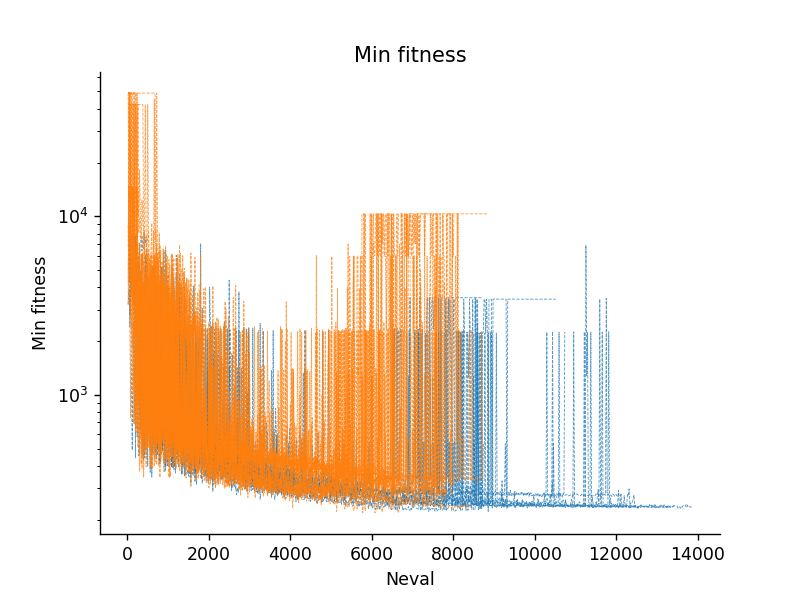

Text(0, 0.5, 'Min fitness')

In [53]:
fig, ax = plt.subplots()
for idx, row in opt_soma.iterrows():
    ax.plot(row["nevals"], 
            row["logbook"].select("min"),
            color="C0",
            ls='--', 
            lw=0.5,
            alpha=0.75)
for idx, row in opt_extra.iterrows():
    ax.plot(row["nevals"], 
            row["logbook"].select("min"),
            color="C1",
            ls='--', 
            lw=0.5,
            alpha=0.75)
    
ax.set_title("Min fitness")
ax.set_yscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Neval")
ax.set_ylabel("Min fitness")

# Load protocols and experimental features

In [12]:
protocols_file = data_folder / "efeatures" / "protocols_BPO_all.json"
feature_file = data_folder / "efeatures" / "features_BPO_all.json"
all_protocols_file = data_folder / "efeatures" / "protocols.json"
all_feature_file = data_folder / "efeatures" / "features.json"
probe_file = data_folder / "efeatures" / "probe_BPO.json"

In [13]:
extra_kwargs = dict(fs=20,
                    fcut=[300, 6000],
                    filt_type="filtfilt",
                    ms_cut=[2, 5]) # use 2-5 to match exp

In [14]:
protocol_for_eap = "IDrest_300"

In [15]:
eva_extra = mf.create_evaluator(
    model_name=model_name,
    cell_model_folder=model_folder,
    feature_set="extra",
    feature_file=feature_file,
    protocol_file=protocols_file,
    probe_file=probe_file,
    protocols_with_lfp=protocol_for_eap,
    morphology_file=morphology_file,
    v_init=-70,
    **extra_kwargs
)

Setting v_init to -70


In [16]:
protocols_opt = list(eva_extra.fitness_protocols.keys())

In [17]:
protocols_opt

['IDrest_150',
 'IDrest_250',
 'IDrest_300',
 'IV_-100',
 'IV_-20',
 'APWaveform_260']

## Load experimental responses

In [18]:
from bluepyefe.extract import read_recordings, extract_efeatures_at_targets, compute_rheobase,\
    group_efeatures, create_feature_protocol_files, convert_legacy_targets
from bluepyefe.plotting import plot_all_recordings_efeatures

from multimodalfitting.efeatures_extraction import build_wcp_metadata, wcp_reader, get_ecode_targets, \
    ecodes_wcp_timings

In [19]:
runs = [2, 3, 4]  # run1 --> different rheobase

ecode_to_index = {
    "IDthres": 0,
    "firepattern": 1,
    "IV": 2,
    "IDrest": 3,
    "APWaveform": 4,
    "HyperDepol": 5,
    "sAHP": 6,
    "PosCheops": 7
}

files_list = []

for run in runs:
    rep_dict = {}
    for ecode in ecode_to_index:
        rep_dict[ecode] = Path(ephys_dir) / f"cell1_run{run}.{ecode_to_index[ecode]}.wcp"
    files_list.append(rep_dict)

In [20]:
# define timings for this experiment
ecodes_cell1_timings = {
    "IDthres": {
        'ton': 200,
        'toff': 470
    },
    "firepattern": {
        'ton': 500,
        'toff': 4100
    },
    "IV": {
        'ton': 250,
        'toff': 3250
    },
    "IDrest": {
        'ton': 200,
        'toff': 1550
    },
    "APWaveform": {
        'ton': 150,
        'toff': 200
    },
    "HyperDepol": {
        'ton': 200,
        'toff': 920,
        'tmid': 650
    },
    "sAHP": {
        'ton': 200,
        'toff': 1125,
        'tmid': 450,
        'tmid2': 675
    },
    "PosCheops": {
        'ton': 1000,
        't1': 9000,
        't2': 10500,
        't3': 14500,
        't4': 16000,
        'toff': 18660
    }
}

In [21]:
files_metadata = build_wcp_metadata(cell_id="cell1_010321", files_list=files_list, 
                                    ecode_timings=ecodes_cell1_timings, 
                                    repetition_as_different_cells=False)
pprint(files_metadata["cell1_010321"])

{'APWaveform': [{'filepath': '../../experimental_data/210301_3113_cell1/patch_data/cell1_run2.4.wcp',
                 'i_unit': 'pA',
                 'ljp': 14.0,
                 't_unit': 's',
                 'toff': 200,
                 'ton': 150,
                 'v_unit': 'mV'},
                {'filepath': '../../experimental_data/210301_3113_cell1/patch_data/cell1_run3.4.wcp',
                 'i_unit': 'pA',
                 'ljp': 14.0,
                 't_unit': 's',
                 'toff': 200,
                 'ton': 150,
                 'v_unit': 'mV'},
                {'filepath': '../../experimental_data/210301_3113_cell1/patch_data/cell1_run4.4.wcp',
                 'i_unit': 'pA',
                 'ljp': 14.0,
                 't_unit': 's',
                 'toff': 200,
                 'ton': 150,
                 'v_unit': 'mV'}],
 'HyperDepol': [{'filepath': '../../experimental_data/210301_3113_cell1/patch_data/cell1_run2.5.wcp',
                 'i_unit': 

In [22]:
cells = read_recordings(
    files_metadata=files_metadata,
    recording_reader=wcp_reader
)

In [23]:
# define target features for different protocols
targets = get_ecode_targets(ecodes_cell1_timings)

targets["firepattern"]["tolerances"] = [20, 40]
targets["IDrest"]["tolerances"] = [20]
targets["PosCheops"]["tolerances"] = [50]
targets["HyperDepol"]["tolerances"] = [30]
targets["APWaveform"]["tolerances"] = [40]
targets["sAHP"]["tolerances"] = [40]

targets = convert_legacy_targets(targets)

In [24]:
compute_rheobase(
    cells, 
    protocols_rheobase=['IDthres']
)

In [25]:
print(f"Cell rheobase: {cells[0].rheobase}")

Cell rheobase: 0.11261744238436222


In [26]:
protocols = group_efeatures(cells, targets, use_global_rheobase=True)

### Build BPO response dicts

In [27]:
responses_experimental = []
num_runs = len(protocols[0].recordings)
for run in range(num_runs):
    print(f"Populating responses for run {run}")
    response_dict = {}
    for protocol in protocols:
        for i, rec in enumerate(protocol.recordings):
            if i == run:
                if protocol.stimulus_name in protocols_opt:
                    response = bpopt.ephys.responses.TimeVoltageResponse(name=protocol.name,
                                                                         time=rec.t, voltage=rec.voltage)
                    response_dict[f"{protocol.stimulus_name}.soma.v"] = response
    responses_experimental.append(response_dict)

Populating responses for run 0
Populating responses for run 1
Populating responses for run 2


<IPython.core.display.Javascript object>


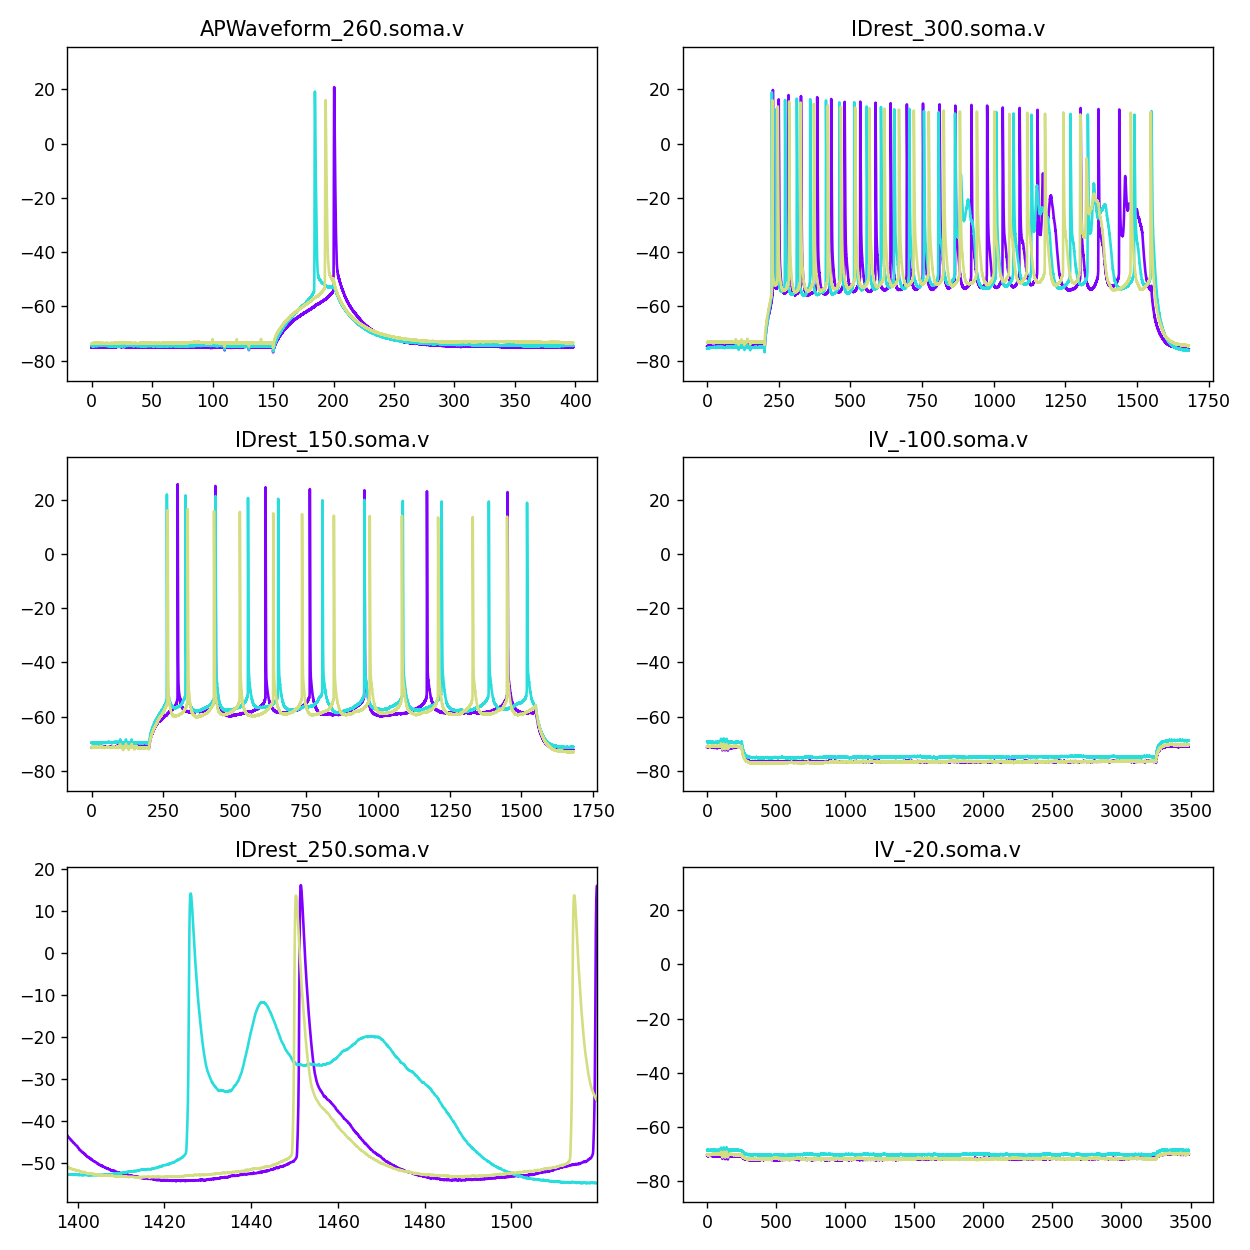

In [91]:
mf.plot_multiple_responses(responses_experimental, max_rows=3)

In [29]:
eap_exp = np.load(data_folder / "efeatures" / "template_BPO.npy") / 1000

<IPython.core.display.Javascript object>


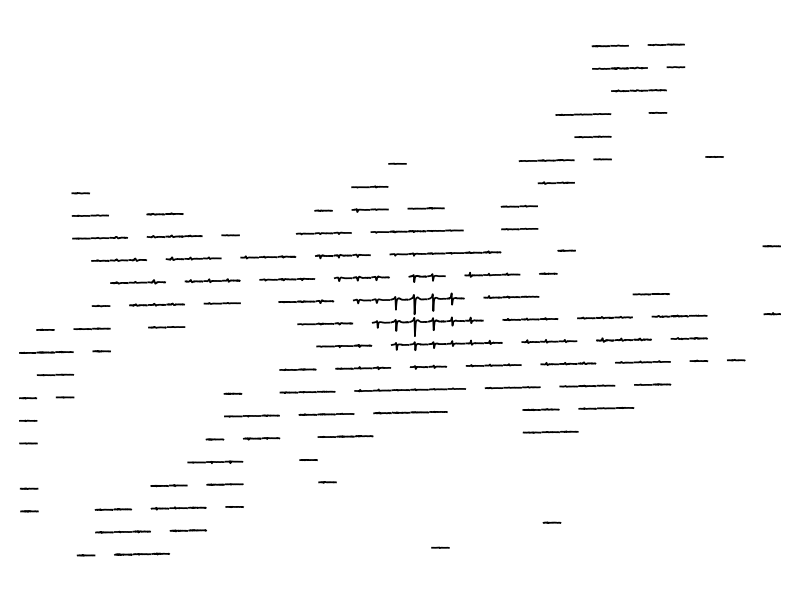

In [30]:
ax = mu.plot_mea_recording(eap_exp, probe)

## "soma" example

In [31]:
best_soma = np.argmin(opt_soma.best_fitness)

In [32]:
params_sample_soma = opt_soma.iloc[best_soma]
params_sample_soma_dict = {k: v for k, v in zip(param_names, params_sample_soma.best_params)}
print(params_sample_soma.best_fitness)

221.77857917439525


In [33]:
response_soma = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), param_values=params_sample_soma_dict)

In [34]:
eap_soma = mf.utils.calculate_eap(responses=response_soma, protocols=eva_extra.fitness_protocols, 
                                  protocol_name=protocol_for_eap, **extra_kwargs)

In [83]:
responses_test = responses_experimental[0]

In [84]:
apwf = responses_test["APWaveform_260.soma.v"]
apwf

In [85]:
import efel

In [86]:
trace = {}
trace["T"] = apwf["time"]
trace["V"] = apwf["voltage"]
trace["stim_start"] = [150]
trace["stim_end"] = [200]

In [87]:
feat = efel.getFeatureValues([trace], ["AP_duration_half_width", "AP_begin_time", "AP_duration", "AP_rise_indices",
                                       "peak_time"])[0]

In [89]:
feat["AP_duration_half_width"]

array([1.2])

<IPython.core.display.Javascript object>


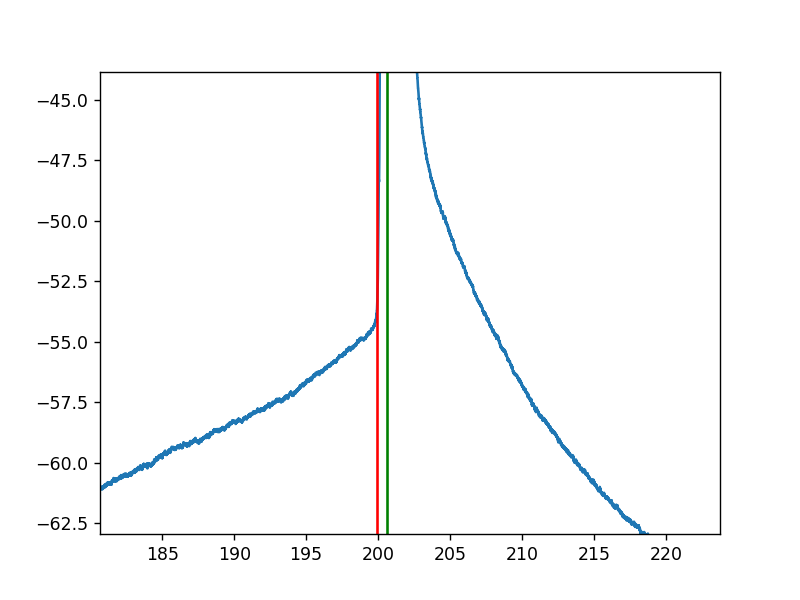

In [90]:
plt.figure()
plt.plot(trace["T"], trace["V"])
plt.axvline(feat["AP_begin_time"][0], color="r")
plt.axvline(feat["peak_time"][0], color="g")

# plt.axvline(150 + trace["T"][feat["peak_indices"][0]], color="r")

<IPython.core.display.Javascript object>


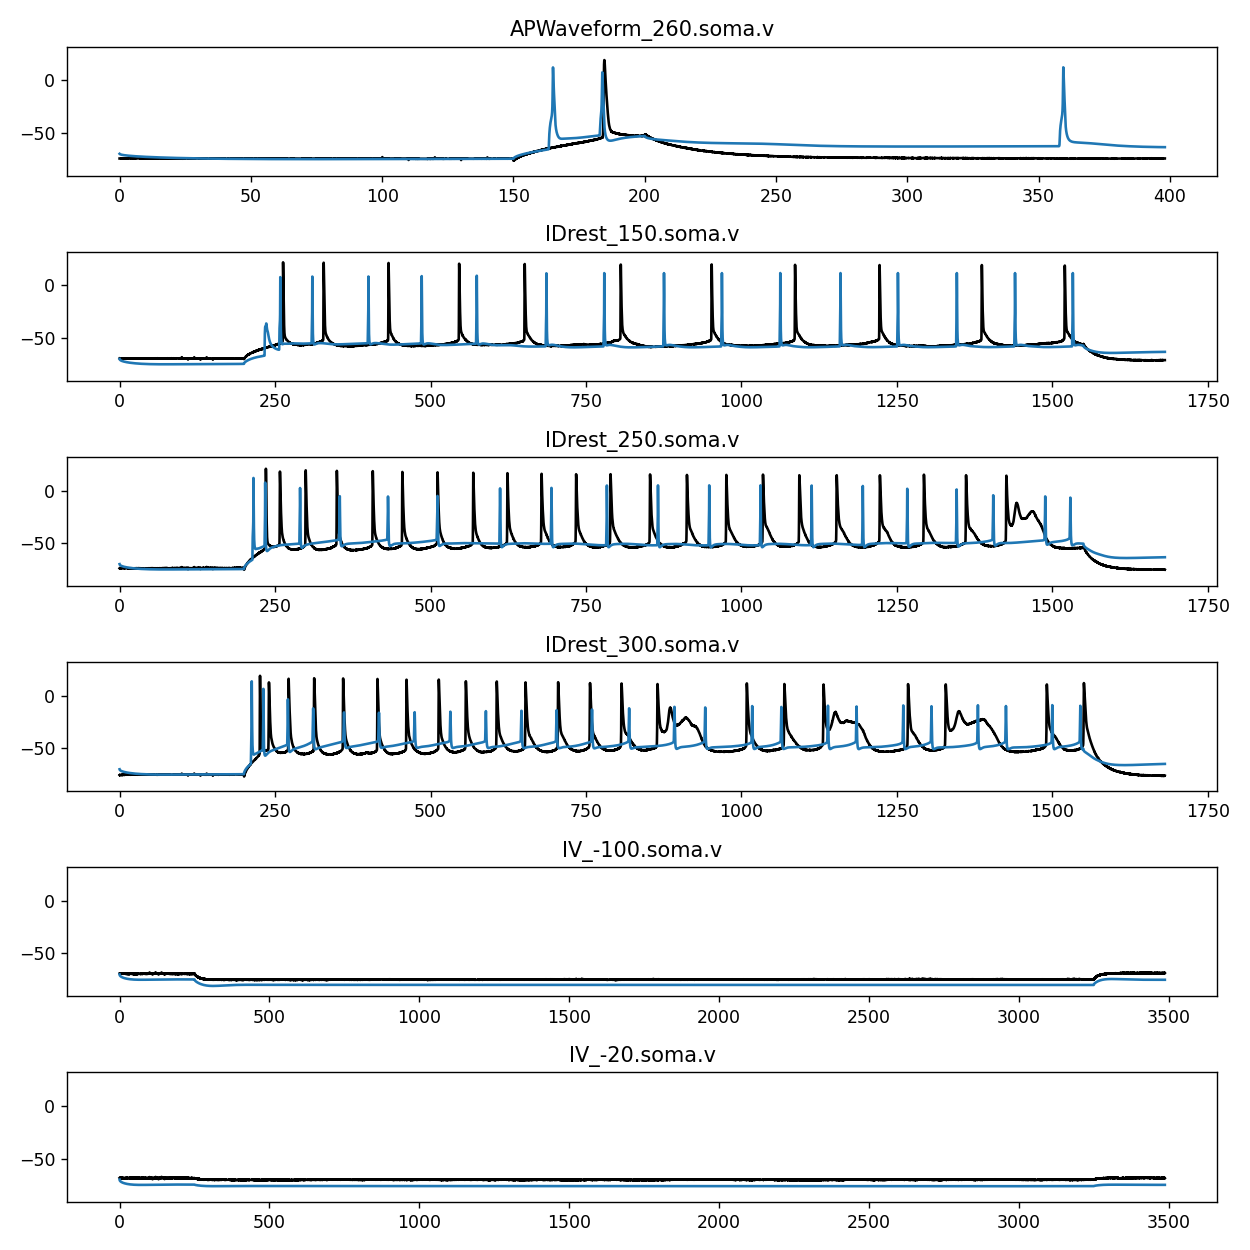

In [59]:
mf.plot_multiple_responses([responses_experimental[1], response_soma], colors=["k", "C0"])

<IPython.core.display.Javascript object>


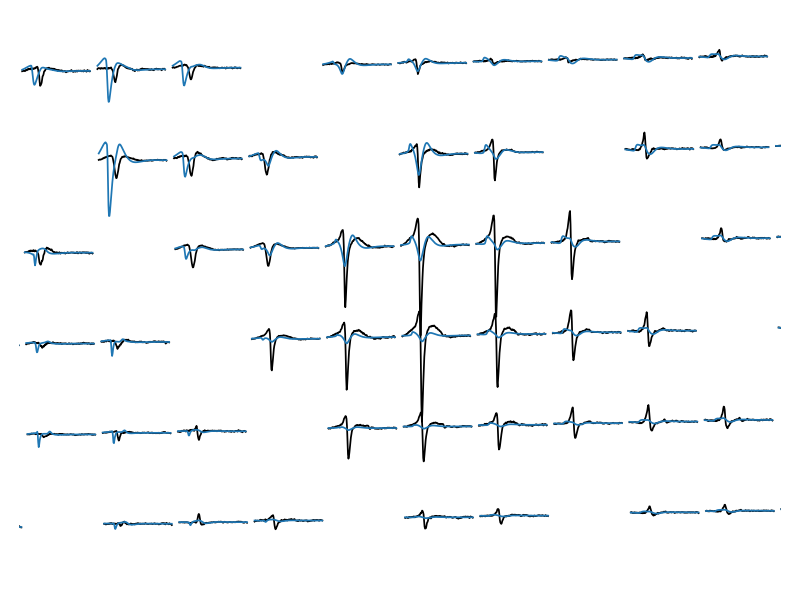

In [49]:
# plot extracellular
vscale = 1 * np.max(np.abs(eap_exp))
ax_soma = mu.plot_mea_recording(eap_exp, probe, vscale=vscale, lw=1)
ax_soma = mu.plot_mea_recording(eap_soma, probe, ax=ax_soma, vscale=vscale, colors="C0", lw=1)

In [38]:
eap_dist_soma = distance.cosine(eap_exp.ravel(), eap_soma.ravel())
print(eap_dist_soma)

0.7640832158150896


## "extra" example

In [39]:
best_extra = np.argmin(opt_extra.best_fitness)

In [40]:
params_sample_extra = opt_extra.iloc[best_extra]
params_sample_extra_dict = {k: v for k, v in zip(param_names, params_sample_extra.best_params)}
print(params_sample_extra.best_fitness, params_sample_extra.extra_strategy)

217.6630949296561 all


In [41]:
response_extra = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), param_values=params_sample_extra_dict)

In [42]:
eap_extra = mf.utils.calculate_eap(responses=response_extra, protocols=eva_extra.fitness_protocols, 
                                protocol_name=protocol_for_eap, **extra_kwargs)

<IPython.core.display.Javascript object>


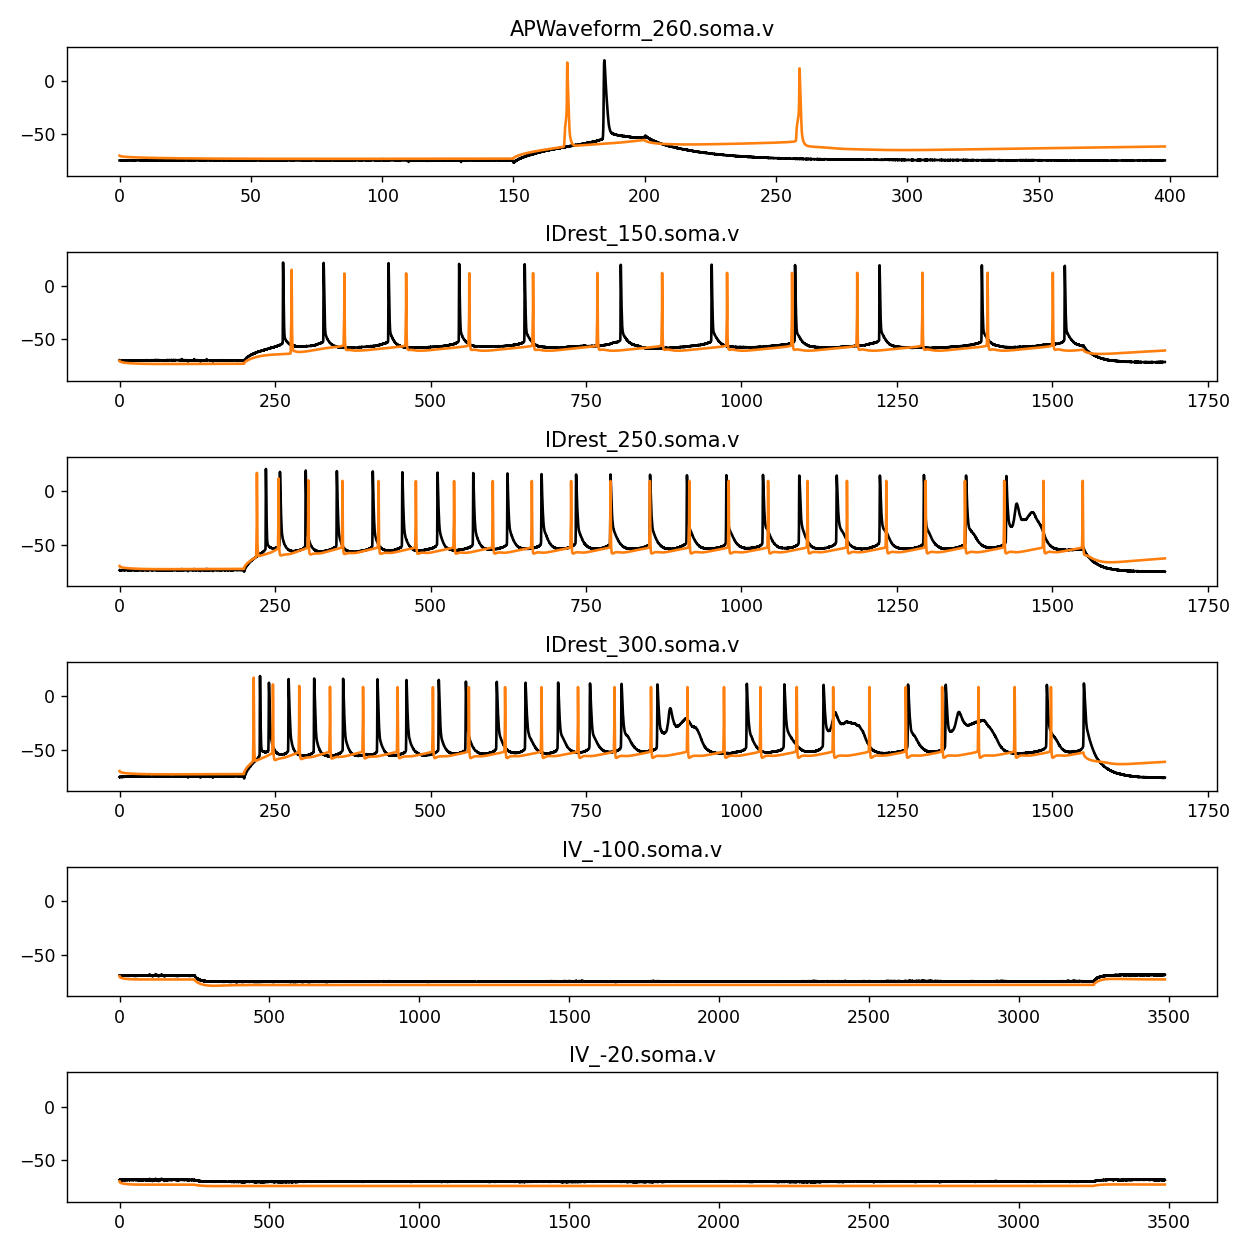

In [51]:
mf.plot_multiple_responses([responses_experimental[1], response_extra], colors=["k", "C1"])

<IPython.core.display.Javascript object>


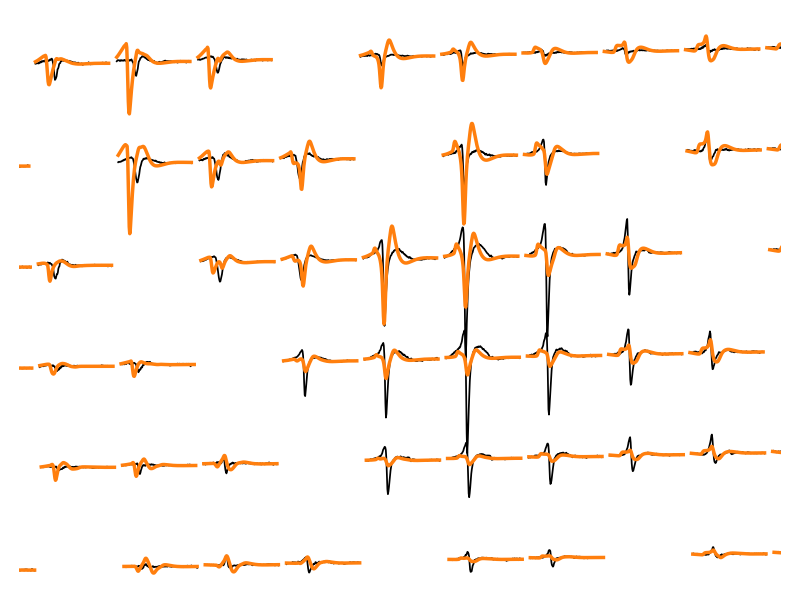

In [48]:
# plot extracellular
vscale = 1 * np.max(np.abs(eap_exp))
ax_extra = mu.plot_mea_recording(eap_exp, probe, vscale=vscale, lw=1)
ax_extra = mu.plot_mea_recording(eap_extra, probe, ax=ax_extra, vscale=vscale, colors="C1", lw=2)

In [45]:
eap_dist_extra = distance.cosine(eap_exp.ravel(), eap_extra.ravel())

In [46]:
print(eap_dist_soma, eap_dist_extra)

0.7640832158150896 0.6003082512215592


## Run protocols and compute features for all tested models


In [ ]:
feats_soma = []
eaps_soma = []
params_soma = []
responses_soma = []

print("SOMA")
for i, (index, opt) in enumerate(opt_soma.iterrows()):
    print(f"Computing {i + 1} / {len(opt_soma)}")
    # get best params
    params_dict = {k: v for k, v in zip(param_names, opt.best_params)}
    params_soma.append(params_dict)
    
    # run protocols
    responses = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), 
                                        param_values=params_dict) 
    responses_soma.append(responses)
    try:
        eap = mf.utils.calculate_eap(responses=responses, protocols=eva_extra.fitness_protocols, 
                                  protocol_name=protocol_for_eap, **extra_kwargs)
    except:
        eap = np.zeros(eaps_soma[-1].shape)
    feat_dict = {}
    for obj in eva_extra.fitness_calculator.objectives:
        feat_dict[obj.features[0].name] = {}
        if len(obj.features) == 1:
            feat_value = obj.features[0].calculate_feature(responses)
            feat_score = obj.features[0].calculate_score(responses)
            feat_dict[obj.features[0].name]["value"] = feat_value
            feat_dict[obj.features[0].name]["score"] = feat_score
        else:
            print(f"More than one feature for objective: {obj.name}")
            
    feats_soma.append(feat_dict)
    eaps_soma.append(eap)
    
print("EXTRA")
feats_extra = []
eaps_extra = []
params_extra = []
responses_extra = []

for i, (index, opt) in enumerate(opt_extra.iterrows()):
    print(f"Computing {i + 1} / {len(opt_soma)}")
    # get best params
    params_dict = {k: v for k, v in zip(param_names, opt.best_params)}
    params_extra.append(params_dict)
    
    # run protocols
    responses = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), 
                                        param_values=params_dict)  
    responses_extra.append(responses)
    try:
        eap = mf.utils.calculate_eap(responses=responses, protocols=eva_extra.fitness_protocols, 
                                  protocol_name=protocol_for_eap, **extra_kwargs)
    except:
        eap = np.zeros(eaps_extra[-1].shape)
        
    feat_dict = {}
    for obj in eva_extra.fitness_calculator.objectives:
        feat_dict[obj.features[0].name] = {}
        if len(obj.features) == 1:
            feat_value = obj.features[0].calculate_feature(responses)
            feat_score = obj.features[0].calculate_score(responses)
            feat_dict[obj.features[0].name]["value"] = feat_value
            feat_dict[obj.features[0].name]["score"] = feat_score
        else:
            print(f"More than one feature for objective: {obj.name}")
            
    feats_extra.append(feat_dict)
    eaps_extra.append(eap)

In [ ]:
feature_set_array = []
seed_array = []
feature_name_array = []
feature_value_array = []
feature_score_array = []
feature_type_array = []

for i, feats in enumerate(feats_soma):
    for feat_name, feat_dict in feats.items():
        feature_set_array.append("soma")
        seed_array.append(i)
        feature_name_array.append(feat_name)
        if "MEA" not in feat_name:
            feature_type_array.append("soma")
            feature_value_array.append(feat_dict["value"])
        else:
            feature_type_array.append("MEA")
            feature_value_array.append(np.nan)
        feature_score_array.append(feat_dict["score"])
    
for i, feats in enumerate(feats_extra):
    for feat_name, feat_dict in feats.items():
        feature_set_array.append("extra")
        seed_array.append(i)
        feature_name_array.append(feat_name)
        if "MEA" not in feat_name:
            feature_type_array.append("soma")
            feature_value_array.append(feat_dict["value"])
        else:
            feature_type_array.append("MEA")
            feature_value_array.append(np.nan)
        feature_score_array.append(feat_dict["score"])
    
df_feats = pd.DataFrame({"seed": seed_array, "feature_set": feature_set_array, "feat_name": feature_name_array,
                         "feat_value": feature_value_array, "feat_score": feature_score_array,
                         "feat_type": feature_type_array})

In [ ]:
df_feats

In [ ]:
plt.figure()
sns.barplot(data=df_feats, x="feature_set", y="feat_score")

In [ ]:
fig = plt.figure()
ax = sns.barplot(data=df_feats.query("feat_type == 'MEA'"), 
            y="feat_name", x="feat_score", hue="feature_set")
sns.despine(left=True, bottom=True)
fig.subplots_adjust(left=0.4)

In [ ]:
fig = plt.figure()
sns.barplot(data=df_feats.query("feat_type == 'soma'"), 
            y="feat_name", x="feat_score", hue="feature_set")
sns.despine(left=True, bottom=True)
fig.subplots_adjust(left=0.4)

## Compare EAP distances

In [ ]:
feature_set_array = []
seed_array = []
eap_dist_array = []

for i, eap in enumerate(eaps_soma):
    feature_set_array.append("soma")
    seed_array.append(i)
    eap_dist_array.append(distance.cosine(eap_exp.ravel(), eap.ravel()))
    
for i, eap in enumerate(eaps_extra):
    feature_set_array.append("extra")
    seed_array.append(i)
    eap_dist_array.append(distance.cosine(eap_exp.ravel(), eap.ravel()))

    
df_eap = pd.DataFrame({"seed": seed_array, "feature_set": feature_set_array, "eap_dist": eap_dist_array})

In [ ]:
fig, ax = plt.subplots()
sns.barplot(data=df_eap, x="feature_set", y="eap_dist", ax=ax)
sns.swarmplot(data=df_eap, x="feature_set", y="eap_dist", dodge=True, ax=ax, palette=["cornflowerblue", "orange"])

# Plot responses

In [ ]:
fig_soma = mf.plot_multiple_responses(responses_list=responses_soma + responses_experimental, 
                                            max_rows=3, colors=["C0"] * len(responses_soma) + ['k'] * 
                                            len(responses_experimental), 
                                            return_fig=True)

In [ ]:
fig_extra = mf.plot_multiple_responses(responses_list=responses_extra + responses_experimental, 
                                             max_rows=3, colors=["C1"] * len(responses_extra) + ['k'] * 
                                             len(responses_experimental), 
                                             return_fig=True)